In [1]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix
from visualization import load_depth, load_stencil, save_pointcloud_csv, bbox_from_string
import progressbar
from joblib import Parallel, delayed
from configparser import ConfigParser
from PIL import Image
import pickle
import json
from datetime import timedelta, datetime, date
from matplotlib.dates import DateFormatter, DateFormatter, HourLocator


In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = CONFIG["Images"]["Tiff"]
#out_directory = r'D:\generic-dataset'
out_directory = r'D:\output-datasets\offroad-7\0'


### showing depth image before and after generic dataset transform

In [3]:
in_depth_file = os.path.join(in_directory, '2018-08-13--11-15-01--499')
out_depth_file = os.path.join(out_directory, '2018-08-13--11-15-01--499-depth.png')
in_depth = load_depth(in_depth_file)
out_depth = np.array(Image.open(out_depth_file))
out_rescaled = out_depth / np.iinfo(np.uint16).max

### histograms

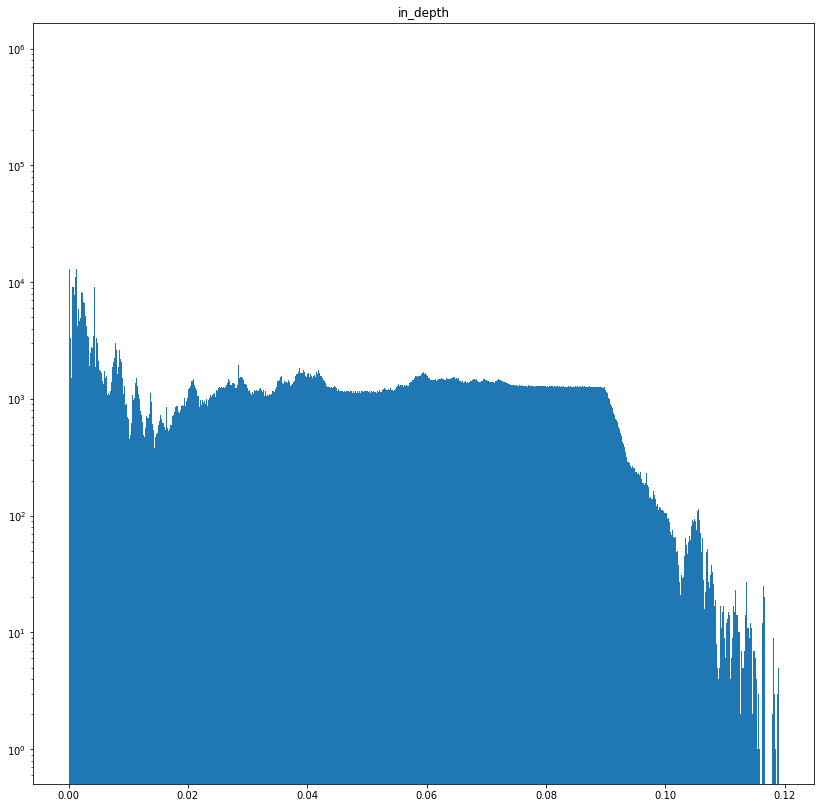

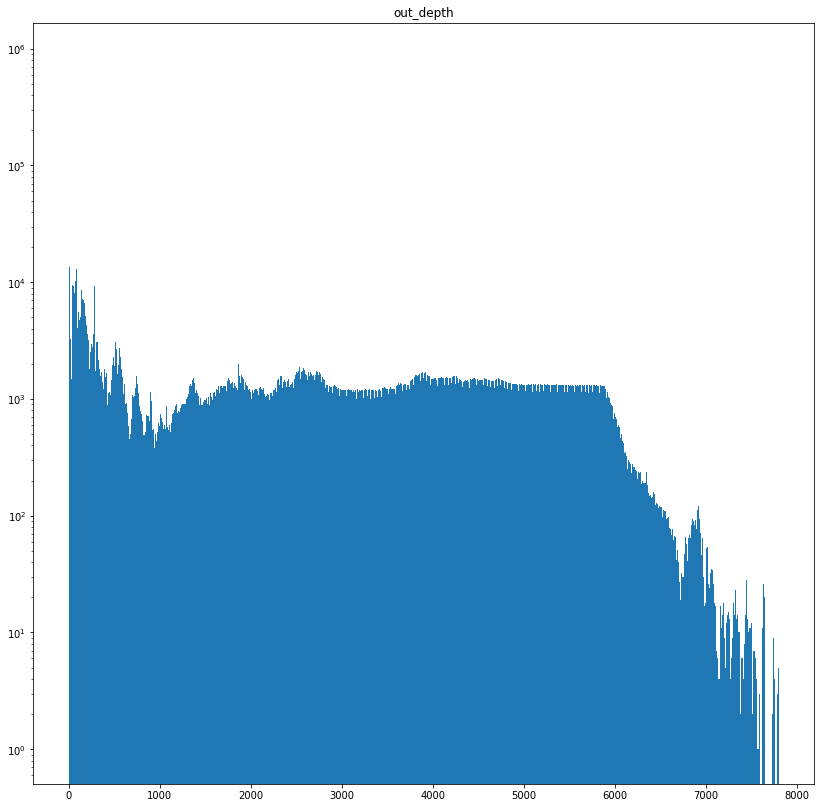

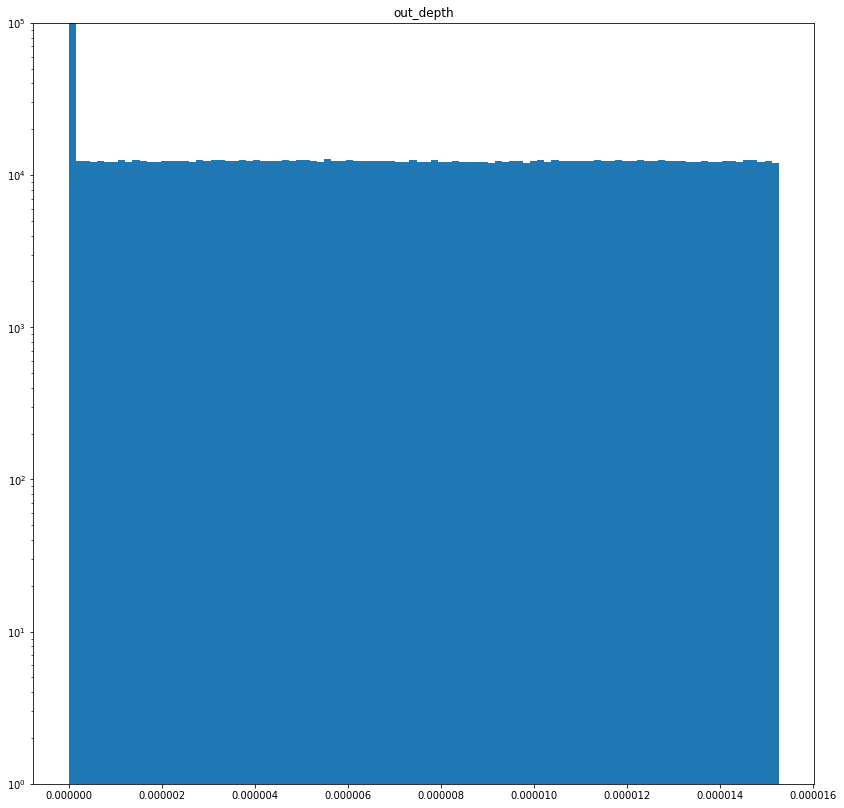

In [4]:
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('in_depth')
plt.hist(in_depth.reshape(-1, 1), bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('out_depth')
plt.hist(out_depth.reshape(-1, 1), bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.gca().set_ylim([1, 1e5])
plt.title('out_depth')
plt.hist(abs(in_depth - out_rescaled).reshape(-1, 1), bins=100)

plt.show()

### showing images

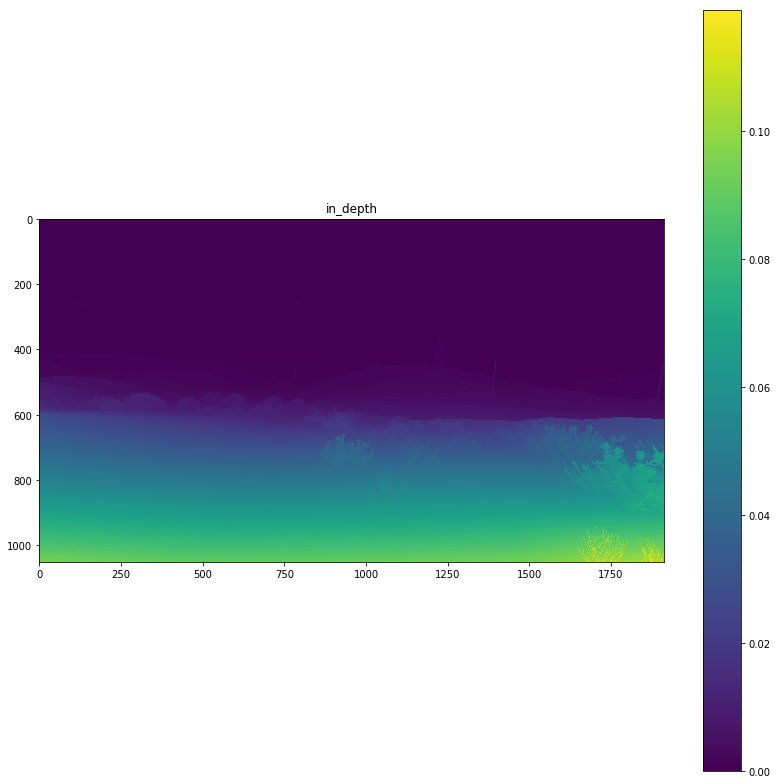

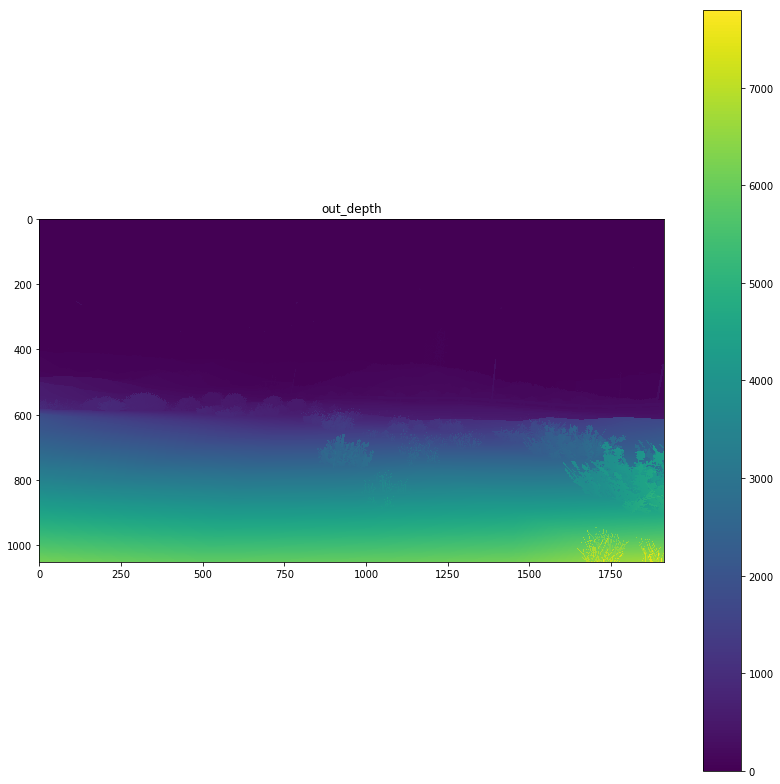

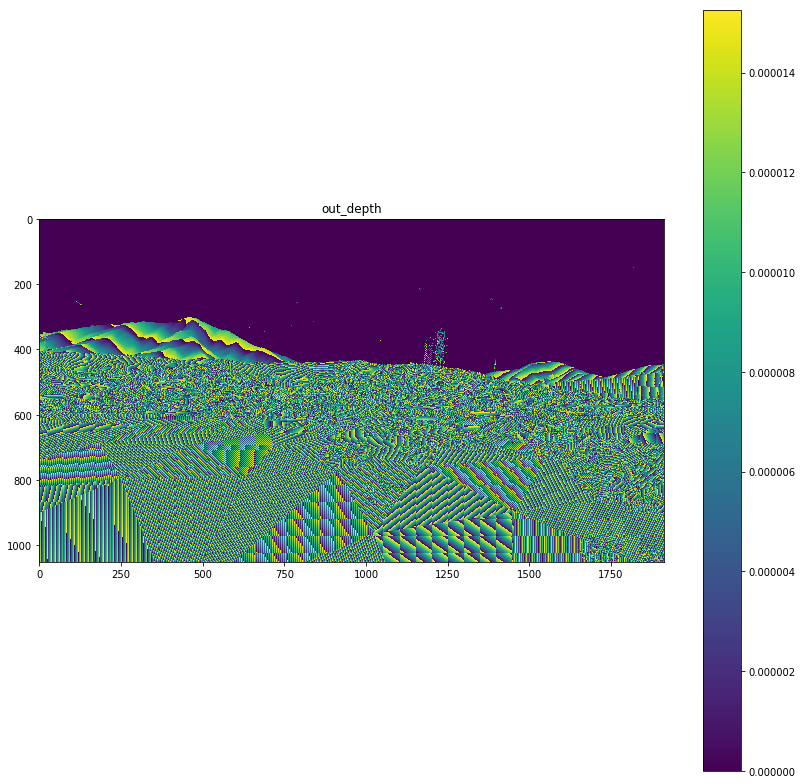

In [5]:
fig = plt.figure(figsize=(14, 14))
plt.title('in_depth')
ii = plt.imshow(in_depth)
plt.colorbar(ii)

fig = plt.figure(figsize=(14, 14))
plt.title('out_depth')
ii = plt.imshow(out_depth)
plt.colorbar(ii)

fig = plt.figure(figsize=(14, 14))
plt.title('out_depth')
ii = plt.imshow(abs(in_depth - out_rescaled))
plt.colorbar(ii)

plt.show()

### showing depth image before and after generic dataset transform

In [6]:
in_stencil_file = os.path.join(in_directory, '2018-03-30--00-59-10--568')
out_stencil_file = os.path.join(out_directory, '2018-03-30--00-59-10--568-stencil.png')
in_stencil = load_stencil(in_stencil_file)
out_stencil = np.array(Image.open(out_stencil_file))

### histograms

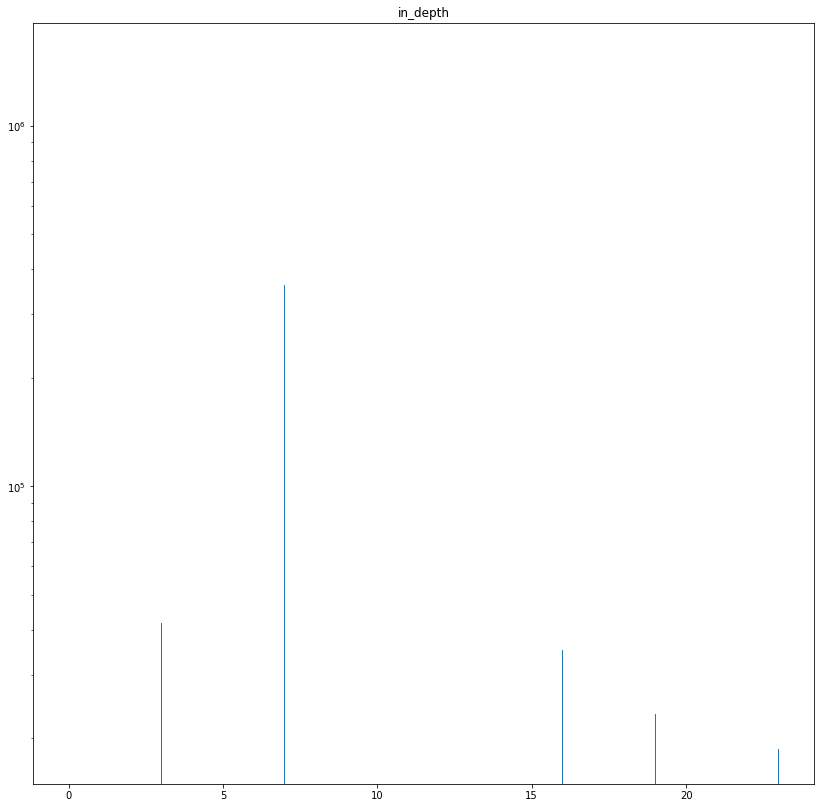

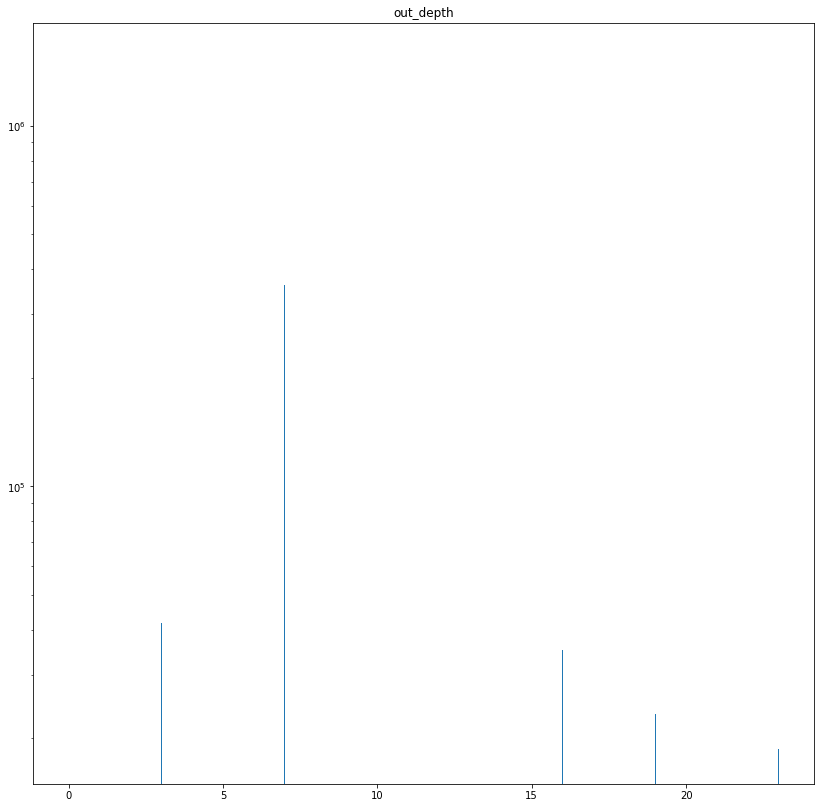

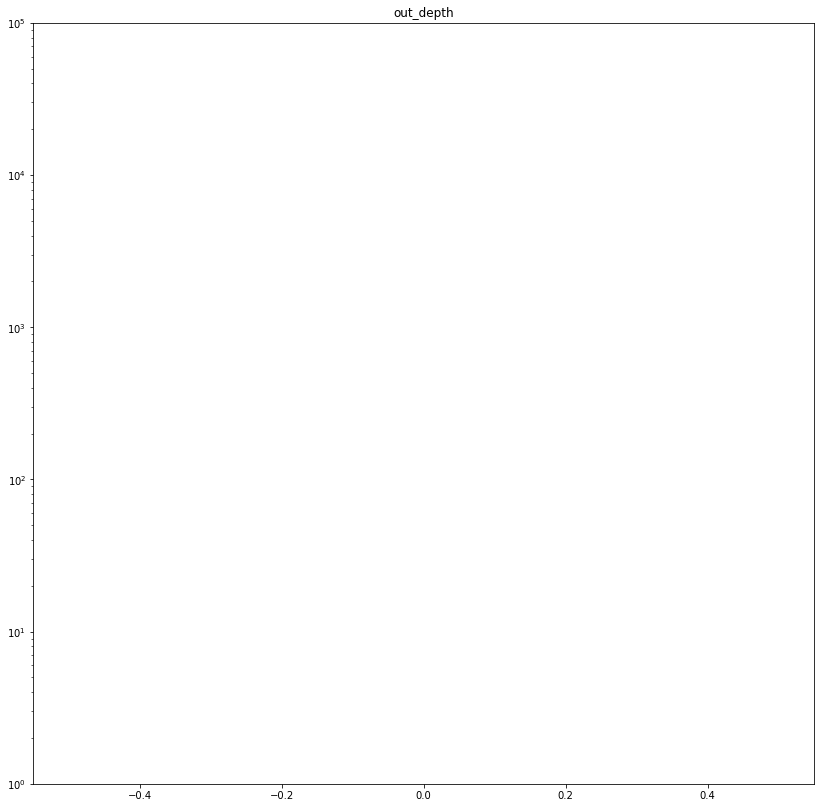

In [7]:
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('in_depth')
plt.hist(in_stencil.reshape(-1, 1), bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('out_depth')
plt.hist(out_stencil.reshape(-1, 1), bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.gca().set_ylim([1, 1e5])
plt.title('out_depth')
plt.hist(abs(in_stencil - out_stencil).reshape(-1, 1), bins=1000)

plt.show()

In [8]:
stencil_diff = abs(in_stencil - out_stencil)
print(np.min(stencil_diff))
print(np.max(stencil_diff))

0
0


In [11]:
#run_id = 6
run_id = 19
#run_id = 3677

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, timestamp, timeofday \
    FROM snapshots \
    WHERE run_id = {} \
    ORDER BY snapshot_id DESC \
    """.format(run_id))

def time_to_sec(t):
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()

def time_to_datetime(t):
    my_day = date(2018, 1, 1)
    return datetime.combine(my_day, t)

results = [dict(res) for res in cur]
timestamps = [i['timestamp'] for i in results]
gametimes = [time_to_datetime(i['timeofday']) for i in results]

In [12]:
print('run size:', len(results))
print('run from:', min(timestamps))
print('run to:', max(timestamps))
total_time = max(timestamps) - min(timestamps)
print('run time:', total_time)
print('images per hour:', total_time / len(results))


run size: 89196
run from: 2018-03-30 00:59:10.574600+00:00
run to: 2018-03-30 10:34:19.219041+00:00
run time: 9:35:08.644441
images per hour: 0:00:00.386886


### showing correlation between real and game time

<class 'datetime.datetime'>
2018-04-16 20:12:05.667805+00:00
2018-01-01 10:22:33


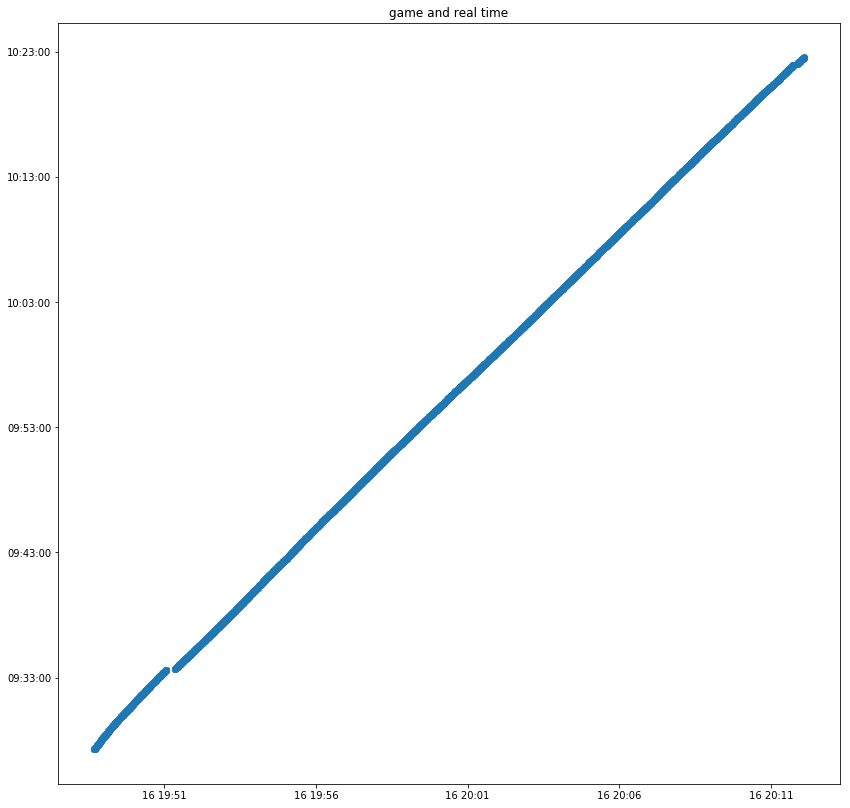

In [5]:
print(type(gametimes[0]))
print(timestamps[0])
print(gametimes[0])
fig = plt.figure(figsize=(14, 14))
plt.title('game and real time')
plt.plot_date(timestamps, gametimes, xdate=True, ydate=True)
plt.gca().yaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.show()

In [2]:
import numpy as np
np.iinfo(np.uint16).max

65535